# Foundation Models

# This notebook is not officially part of the course.

But you are welcome to look through it anyways, you can send questions on slack, and we are happy to talk about it.  

Author: Corey Adams

The previous notebook trained a classifier network which did ok.  But what if we didn't have a lot of data?  In this notebook, we'll apply that model in a new way with _representation learning_.

In [1]:
import numpy, random
import torch
import torchvision
from torchvision.transforms import v2


import torch.distributed as dist
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as mp

from torch.nn.parallel import DistributedDataParallel as DDP

batch_size = 128



/soft/datascience/conda/2023-10-04/mconda3/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/soft/datascience/conda/2023-10-04/mconda3/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback

Here's the Convolutional Neural Network Again:

In [2]:
from torch import nn

class Downsampler(nn.Module):

    def __init__(self, in_channels, out_channels, stride=2):
        super(Downsampler, self).__init__()

        self.norm = nn.InstanceNorm2d(in_channels)

        self.downsample = nn.Conv2d(
            in_channels=in_channels, 
            out_channels=out_channels,
            kernel_size = stride,
            stride = stride,
        )
    
    def forward(self, inputs):

        return self.downsample(self.norm(inputs))
        
        

class ConvNextBlock(nn.Module):
    """This block of operations is loosely based on this paper:

    """


    def __init__(self, in_channels):
        super(ConvNextBlock, self).__init__()

        # Depthwise, seperable convolution with a large number of output filters:
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=in_channels, 
                                     groups=in_channels,
                                     kernel_size=[7,7],
                                     padding='same' )

        self.norm = nn.InstanceNorm2d(in_channels)

        # Two more convolutions:
        self.conv2 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=4*in_channels,
                                     kernel_size=1)

        self.conv3 = nn.Conv2d(in_channels=4*in_channels, 
                                     out_channels=in_channels,
                                     kernel_size=1
                                     )


    def forward(self, inputs):
        x = self.conv1(inputs)

        # The normalization layer:
        x = self.norm(x)

        x = self.conv2(x)

        # The non-linear activation layer:
        x = torch.nn.functional.gelu(x)

        x = self.conv3(x)

        # This makes it a residual network:
        return x + inputs
    

class Classifier(nn.Module):


    def __init__(self, n_initial_filters, n_stages, blocks_per_stage, n_outputs):
        super(Classifier, self).__init__()

        # This is a downsampling convolution that will produce patches of output.

        # This is similar to what vision transformers do to tokenize the images.
        self.stem = nn.Conv2d(in_channels=3,
                                    out_channels=n_initial_filters,
                                    kernel_size=1,
                                    stride=1)
        
        self.norm1 = nn.InstanceNorm2d(n_initial_filters)

        current_n_filters = n_initial_filters
        
        self.layers = nn.Sequential()
        for n_blocks in range(n_stages):
            # Add a convnext block series:
            for _ in range(blocks_per_stage):
                self.layers.append(ConvNextBlock(in_channels=current_n_filters))
            # Add a downsampling layer:
            self.layers.append(Downsampler(in_channels=current_n_filters, out_channels=2*current_n_filters))
            # Double the number of filters:
            current_n_filters = 2*current_n_filters


        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LayerNorm(current_n_filters),
            nn.Linear(current_n_filters, n_outputs)
        )

    def forward(self, inputs):

        x = self.stem(inputs)
        # Apply a normalization after the initial patching:
        x = self.norm1(x)

        # Apply the main chunk of the network:
        x = self.layers(x)

        # Normalize and readout:
        x = nn.functional.avg_pool2d(x, x.shape[2:])
        x = self.head(x)

        return x



In [3]:
def create_representation_model(n_features, rank, size):

    model = Classifier(32, 2, 2, n_features)


    model.to(f"cuda:{rank}")

    return model

model = create_representation_model(256, 0, 1)

head = torch.nn.Sequential(
    nn.Linear(256,128),
)

head.to(f"cuda:0")

from torchinfo import summary
    
print(summary(model, input_size=(batch_size, 3, 32, 32)))
print(summary(head, input_size=(batch_size, 256)))


Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [128, 256]                --
├─Conv2d: 1-1                            [128, 32, 32, 32]         128
├─InstanceNorm2d: 1-2                    [128, 32, 32, 32]         --
├─Sequential: 1-3                        [128, 128, 8, 8]          --
│    └─ConvNextBlock: 2-1                [128, 32, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 32, 32, 32]         1,600
│    │    └─InstanceNorm2d: 3-2          [128, 32, 32, 32]         --
│    │    └─Conv2d: 3-3                  [128, 128, 32, 32]        4,224
│    │    └─Conv2d: 3-4                  [128, 32, 32, 32]         4,128
│    └─ConvNextBlock: 2-2                [128, 32, 32, 32]         --
│    │    └─Conv2d: 3-5                  [128, 32, 32, 32]         1,600
│    │    └─InstanceNorm2d: 3-6          [128, 32, 32, 32]         --
│    │    └─Conv2d: 3-7                  [128, 128, 32, 32]        4,224

This will download the data if needed:


We're going to train this on Polaris nodes which have 4 A100s (But only using one node at a time).  So, the following helper functions will automatically distribute the code and model to use all 4 GPUs at once:

(They are all from the [DDP Tutorial](https://pytorch.org/tutorials/intermediate/ddp_tutorial.html) )

In [4]:

def setup(rank, world_size):
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12355'

    # initialize the process group
    dist.init_process_group("gloo", rank=rank, world_size=world_size)

def cleanup():
    dist.destroy_process_group()

In [5]:
def create_data_loaders(transforms, batch_size, rank, seed):
    # Start up the data loader:
    dev = torch.device(
        f"cuda:{rank}") if torch.cuda.is_available() else torch.device("cpu")

    training_data = torchvision.datasets.CIFAR10(
        root="data",
        train=True,
        download=True,
        transform=transforms
    )
    
    training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))
    
    # The dataloader makes our dataset iterable 
    train_dataloader = torch.utils.data.DataLoader(training_data, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, 
                                                   num_workers=8)
    
    val_dataloader = torch.utils.data.DataLoader(validation_data, 
                                                 batch_size=batch_size, 
                                                 shuffle=True, 
                                                 num_workers=8)
    

    def preprocess(x, y):
        # CIFAR-10 is *color* images so 3 layers!
        return x.view(-1, 3, 32, 32).to(dev), y.to(dev)
    
    
    class WrappedDataLoader:
        def __init__(self, dl, func):
            self.dl = dl
            self.func = func
    
        def __len__(self):
            return len(self.dl)
    
        def __iter__(self):
            for b in self.dl:
                yield (self.func(*b))


    train_dataloader = WrappedDataLoader(train_dataloader, preprocess)
    val_dataloader = WrappedDataLoader(val_dataloader, preprocess)

    return train_dataloader, val_dataloader

In [6]:


# def demo_basic(rank, world_size, n_epochs):
#     print(f"Running basic DDP example on rank {rank}.")
#     setup(rank, world_size)

    
#     # create model and move it to GPU with id rank
#     model = ToyModel().to(rank)
#     ddp_model = DDP(model, device_ids=[rank])

#     loss_fn = nn.MSELoss()
#     optimizer = optim.SGD(ddp_model.parameters(), lr=0.001)

#     optimizer.zero_grad()
#     outputs = ddp_model(torch.randn(20, 10))
#     labels = torch.randn(20, 5).to(rank)
#     loss_fn(outputs, labels).backward()
#     optimizer.step()

#     cleanup()


# def run_demo(demo_fn, world_size):
#     mp.spawn(demo_fn,
#              args=(world_size,5),
#              nprocs=world_size,
#              join=True)

In [7]:
# import sys, os
# from multiprocessing import Pool
# from multiprocessing.reduction import ForkingPickler
# from types import FunctionType
# import cloudpickle

# assert sys.version_info >= (3, 8), 'python3.8 or greater required to use reducer_override'

# def reducer_override(obj):
#     if type(obj) is FunctionType:
#         return (cloudpickle.loads, (cloudpickle.dumps(obj),))
#     else:
#         return NotImplemented

# # Monkeypatch our function reducer into the pickler for multiprocessing.
# # Without this line, the main block will not work on windows or macOS.
# # Alterntively, moving the defintionn of foo outside of the if statement
# # would make the main block work on windows or macOS (when run from
# # the command line).
# ForkingPickler.reducer_override = staticmethod(reducer_override)

In [14]:


# This method is from the pytorch implementation of SimCLR:
# https://github.com/sthalles/SimCLR/blob/master/data_aug/contrastive_learning_dataset.py

def get_simclr_pipeline_transform(size, s=1):
    """Return a set of data augmentation transformations as described in the SimCLR paper."""
    color_jitter = v2.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)
    data_transforms = v2.Compose([v2.RandomResizedCrop(size=size, scale=[0.85,1.0]),
                                          v2.RandomHorizontalFlip(),
                                          v2.RandomApply([color_jitter], p=0.8),
                                          v2.RandomGrayscale(p=0.2),
                                          v2.ToDtype(torch.float32),#v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
                                          # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                          # v2.ToTensor()
                                        ])
    return data_transforms

In [15]:
transforms1 = get_simclr_pipeline_transform((32,32))
transforms2 = get_simclr_pipeline_transform((32,32))

In [16]:
train, val = create_data_loaders(v2.ToTensor(), batch_size, 0, seed = 1234)



/soft/datascience/conda/2023-10-04/mconda3/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


Files already downloaded and verified


In [17]:
batch, (X, Y) = next(enumerate(train))


In [18]:
X1 = transforms1(X); X2 = transforms2(X)

print(type(X1))
print(type(X2))

<class 'torch.Tensor'>
<class 'torch.Tensor'>


/soft/datascience/conda/2023-10-04/mconda3/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [19]:
from matplotlib import pyplot as plt
%matplotlib inline

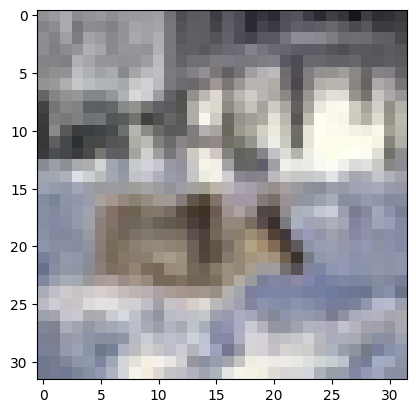

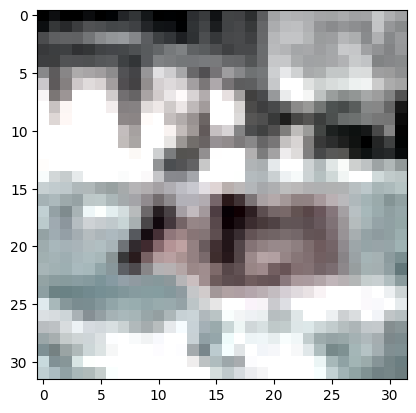

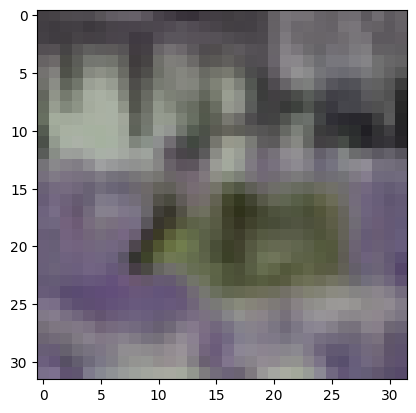

In [20]:
plt.imshow(X[0].cpu().permute((1,2,0))); plt.show()
plt.imshow(X1[0].cpu().permute((1,2,0))); plt.show()
plt.imshow(X2[0].cpu().permute((1,2,0))); plt.show()


In [21]:
def contrastive_loss(first_images, second_images, rank, world_size = 1, temperature=0.1):
        # Each image is represented with k parameters,
        # Assume the batch size is N, so the
        # inputs have shape (N, k)

        # These are pre-distributed shapes:
        N = first_images.shape[0]
        k = first_images.shape[1]


        first_images = first_images / torch.norm(first_images,dim=1).reshape((-1,1))
        second_images = second_images / torch.norm(second_images,dim=1).reshape((-1,1))

        # Take the two tuples, and concatenate them.
        # Then, reshape into Y = (1, 2N, k) and Z = (2N, 1, k)

        c = torch.concat([first_images, second_images], dim=0)

        # Gather all the c up if the world size > 1:
        if world_size > 1:
            gathered_c = torch.distributed.all_gather(tensor=c)
            gathered_c = gathered_c.reshape((-1, first_images.shape[-1]))
        else:
            gathered_c = c

        # Each rank computes only a slice of the global loss matrix, or
        # the memory usage gets out of control.

        # We calculate the dot product between the local and global tensors:
        local_reps = c.reshape((c.shape[0], 1, c.shape[1]))
        all_reps   = gathered_c.reshape((1, gathered_c.shape[0], gathered_c.shape[1]))


        # Assume we have n images per rank, for N global images with N = n * world_size
        # Compute the product of these tensors, which gives shape
        # (2n, 2N, k)
        mat =  local_reps*all_reps

        # We need to compute the function (sim(x,y)) for each element in the 2N sequent.
        # Since the are normalized, we're computing x^T . Y / (||x||*||y||),
        # but the norms are equal to 1.
        # So, summing the matrix over the dim = 0 and dim = 1 computes this for each pair.

        sim = torch.sum(mat, dim=-1) / temperature



        # Now, sim is of shape [2*n, 2*N]

        # This yields a symmetric matrix, diagonal entries equal 1.  Off diagonal are symmetrics and < 1.

        # sim = torch.exp(sim / temperature)
        # Now, for every entry i in C (concat of both batches), the sum of sim[i] - sim[i][i] is the denominator

        device = sim.device

        # Since we have a non-symmetric matrix, need to build a non-symmetric index:
        positive = torch.zeros(sim.shape, device=device)

        # We concatenated all the local examples, and compute symmetric positive pairs
        # So for the first N entries, the index of the positive pair is i + N  (locally)
        # For the second N entries, the index of the positive pair is i - N (locally)
        # with a distributed run, we've squashed all the similarity scores together.
        # to a shape of [2*N, 2*N*Size]
        # Each 2*N by 2*N block is the local positive indexes, all others are negative.
        # That means that the index is shifted by global_rank*2*N

        access_index_x = torch.arange(2*N)
        # For the first N, the y-index is equal to x + 2*N
        # For the second N
        access_index_y = torch.arange(2*N)
        # Shift by +/- N:
        access_index_y[0:N] = access_index_y[0:N] + N
        access_index_y[N:]  = access_index_y[N:] - N

        access_index_y +=  rank * 2*N

        # print("access_index_y: ", access_index_y, flush=True)

        positive[access_index_x, access_index_y] = 1

        # For the negative, we invert the positive and have to 0 out the self-index entries
        negative = 1 - positive

        # THESE WORK IF IT'S NOT DISTRIBUTED
        # positive = torch.tile(torch.eye(N, device=device), (2,2))
        # # Unsure if this line is needed?
        # positive = positive - torch.eye(2*N, device=device)
        #
        # negative = - (torch.eye(2*N, device=device) - 1)

        with torch.no_grad():
            # Here, we can compute the top-k metrics for this batch, since we have the global state:
            # We want the top 5 entries but the self-sim is obviously perfect.
            # So take the top 6 and reject the first.
            topk = torch.topk(sim, k=6, dim=-1, sorted=True)

            # Top 1 is just an equality check:
            top1_acc = topk.indices[:,1] == access_index_y.to(topk.indices.device)
            top1_acc = torch.mean(top1_acc.to(torch.float))
          
            # Top 5 is a little more complicated:
            # Compute the index distance to the correct index, abs value:
            top5_acc_dist = torch.abs(topk.indices[:,1:] - access_index_y.to(topk.indices.device).reshape(-1,1))
            # Get the minumum value, and see if it is less than 5:
            min_values, _ = torch.min(top5_acc_dist, dim=-1)
            top5_acc =  min_values < 5.
            # Average over the batch dimension:
            top5_acc = torch.mean(top5_acc.to(torch.float))


        negative_examples = sim * negative
        positive_examples = sim * positive

        # Now, positive/negative examples is the temperature normalized similarity.
        # we need to sum across the whole batch dimension to compute it per-example:


        # Compute the alignment, summed over the entire global batch:
        alignment = torch.sum(positive_examples, dim=-1)

        # Compute the exp, which we'll eventually sum and log:
        exp = torch.sum(torch.exp(negative_examples), dim=-1)

        # print("Alignment: ", alignment, flush=True)
        # print("exp: ",       exp, flush=True)


        # And compute the logsumexp of the negative examples:
        log_sum_exp = torch.log(exp )


        # Additionally, we can compute the "floor" of the loss at this batch size:
        # floor = torch.log(1.*N) - 1.

        loss_metrics = {
            "alignment"   : torch.mean(alignment),
            "log_sum_exp" : torch.mean(log_sum_exp),
            "top1"        : top1_acc,
            "top5"        : top5_acc,
            # "floor"       : floor,
        }

        loss = torch.mean( - alignment + log_sum_exp)
        return loss, loss_metrics


In [22]:
def train_one_epoch(dataloader, t1, t2, model, head, loss_fn, optimizer, rank, size, progress_bar):
    model.train()
    head.train()
    for (batch, (X, _)) in enumerate(dataloader):
        # forward pass
        X1 = t1(X); X2 = t2(X)
        pred1 = head(model(X1))
        pred2 = head(model(X2))
        loss, metrics = loss_fn(pred1, pred2, rank, size)

        # print(metrics)
        
        # backward pass calculates gradients
        loss.backward()
        
        # take one step with these gradients
        optimizer.step()
        
        # resets the gradients 
        optimizer.zero_grad()

        # progress_bar.refresh()
        cpu_metrics = { key : f"{metrics[key].detach().cpu().numpy():.2f}" for key in metrics.keys()}
        cpu_metrics["loss"] = f"{loss.detach().cpu().numpy():.2f}"
        progress_bar.update()
        progress_bar.set_postfix(cpu_metrics)
        # progress_bar.description = f"Train loss: {loss.cpu():.2f} top5: {metrics['top5'].cpu():.2f}"
        # break

In [23]:
def validate_one_epoch(dataloader, t1, t2, model, head, loss_fn, rank, size, progress_bar):
    model.train()
    head.train()
    n = 0.
    sum_metrics = None
    for (batch, (X, _)) in enumerate(dataloader):
        # forward pass
        X1 = t1(X); X2 = t2(X)
        pred1 = head(model(X1))
        pred2 = head(model(X2))
        loss, metrics = loss_fn(pred1, pred2, rank, size)

        # print(metrics)
        
        # backward pass calculates gradients
        loss.backward()
        
        # take one step with these gradients
        optimizer.step()
        
        # resets the gradients 
        optimizer.zero_grad()

        # progress_bar.refresh()
        cpu_metrics = { key : metrics[key].detach().cpu().numpy() for key in metrics.keys()}
        if sum_metrics is None: 
            sum_metrics = cpu_metrics
        else:
            for key in sum_metrics.keys():
                sum_metrics[key] += cpu_metrics[key]
        progress_bar.update()
        n += 1.
        # progress_bar.description = f"Train loss: {loss.cpu():.2f} top5: {sum_metrics['top5'].cpu():.2f}"
        # break
    
    for key in sum_metrics:
        sum_metrics[key] = sum_metrics[key] / n
    return sum_metrics

In [24]:
optimizer = torch.optim.AdamW(list(model.parameters()) + list(head.parameters()), lr=0.001)

In [25]:
from tqdm.notebook import tqdm


for j in range(5):
    # with tqdm(total=len(train), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar1:
    
    #     train_one_epoch(train, transforms1, transforms2, model, head, contrastive_loss, optimizer, 0, 1, train_bar1)

    with tqdm(total=len(val), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:
        metrics = validate_one_epoch(val, transforms1, transforms2, model, head, contrastive_loss, 0, 1, val_bar)
        print_metrics = {
            key : f"{key}={metrics[key]:.2f}" for key in metrics.keys()
        }
        print_metrics = "; ".join(print_metrics.values())
        print(f"Validate epoch {j}: ", print_metrics)


Validate Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Validate epoch 0:  alignment=8.88; log_sum_exp=12.15; top1=0.39; top5=0.69


Validate Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Validate epoch 1:  alignment=9.11; log_sum_exp=11.31; top1=0.67; top5=0.90


Validate Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Validate epoch 2:  alignment=9.16; log_sum_exp=10.97; top1=0.78; top5=0.94


Validate Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Validate epoch 3:  alignment=9.17; log_sum_exp=10.88; top1=0.80; top5=0.95


Validate Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Validate epoch 4:  alignment=9.27; log_sum_exp=10.79; top1=0.87; top5=0.98


In [26]:
# Now, we retrain the classification head without touching the representation. This is called fine tuning.


In [27]:
def evaluate(dataloader, model, head, loss_fn, val_bar):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing 
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:

            pred = head(model(X))
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            val_bar.update()
            
    loss /= num_batches
    correct /= (size*batch_size)
    
    accuracy = 100*correct
    return accuracy, loss

In [28]:
def fine_tune(dataloader, rep_model, head, loss_fn, optimizer, progress_bar):
    head.train()
    model.eval()
    for batch1, (X, Y) in enumerate(dataloader):
        # forward pass
        # Calling detach blocks all gradients into the representation model!
        rep = rep_model(X).detach()
        pred = head(rep)
        loss = loss_fn(pred, Y)
        
        
        # backward pass calculates gradients
        loss.backward()
        
        # take one step with these gradients
        optimizer.step()
        
        # resets the gradients 
        optimizer.zero_grad()

        correct = (pred.argmax(1) == Y).type(torch.float).mean().item()
                    
        # progress_bar.refresh()
        cpu_metrics = {}
        cpu_metrics["acc"] = f"{correct:.2f}"
        cpu_metrics["loss"] = f"{loss.detach().cpu().numpy():.2f}"
        progress_bar.update()
        progress_bar.set_postfix(cpu_metrics)
        # progress_bar.description = f"Train loss: {loss.cpu():.2f} top5: {metrics['top5'].cpu():.2f}"
        # break

In [29]:
classification_head = nn.Linear(256, 10).cuda()
classification_loss = loss_fn = nn.CrossEntropyLoss()
fine_tune_optimizer = torch.optim.AdamW(classification_head.parameters(), lr=0.01)
print(fine_tune_optimizer)

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0.01
)


In [30]:

for j in range(5):
    with tqdm(total=len(train), position=0, leave=True, desc=f"Fine Tune Epoch {j}") as train_bar1:
    
        fine_tune(train, model, classification_head, classification_loss, fine_tune_optimizer, train_bar1)
    with tqdm(total=len(val), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:
        acc, loss = evaluate(val, model, classification_head, classification_loss, val_bar)
        print(f"Epoch {j}: validation loss: {loss:.3f}, accuracy: {acc:.3f}")


Fine Tune Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0: validation loss: 2.015, accuracy: 27.660


Fine Tune Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1: validation loss: 2.015, accuracy: 28.402


Fine Tune Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2: validation loss: 1.982, accuracy: 27.749


Fine Tune Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3: validation loss: 1.979, accuracy: 28.372


Fine Tune Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4: validation loss: 1.944, accuracy: 30.044
